#Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('boston.csv')
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


## Split data: train-validation-test

In [3]:
# split train test
from sklearn.model_selection import train_test_split

feature = df.drop(columns='medv')
target = df[['medv']]

# First splitting: pretrain and test
feature_df_pretrain, feature_df_test, target_df_pretrain, target_df_test = train_test_split(feature, target, test_size=0.20, random_state=42)

# Second splitting: train and validation
feature_df_train, feature_df_validation, target_df_train, target_df_validation = train_test_split(feature_df_pretrain, target_df_pretrain, test_size=0.20, random_state=42)

### Multicollinearity Study

In [4]:
# calculate VIF scores for each feature
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif 
from statsmodels.tools.tools import add_constant

X = add_constant(feature_df_train)

vif_df = pd.DataFrame([vif(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns).reset_index()
vif_df.columns = ['feature','vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,feature,vif_score
1,crim,1.750939
2,zn,2.473421
3,indus,3.741988
4,chas,1.110042
5,nox,4.585650
6,rm,1.972174
7,age,3.127443
8,dis,4.390458
9,rad,7.182410
10,tax,8.268145


this data has many features with moderately high VIF values,next we need proceed to draw a correlation heatmap so we can determine which features should be dropped

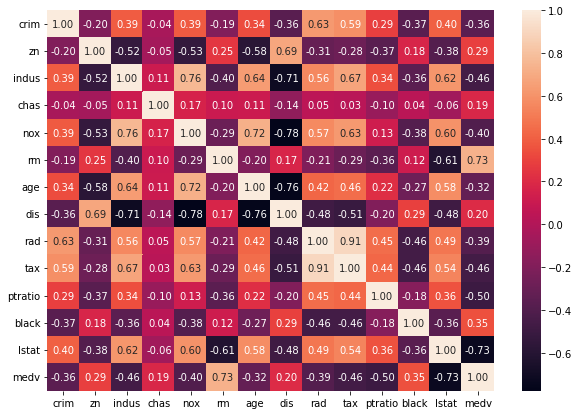

In [7]:
# heatmap correlation
df_train = pd.concat([feature_df_train, target_df_train], axis=1)
corr = df_train.corr()

plt.figure(figsize=(10,7))
sns.heatmap(corr, annot=True, fmt='.2f')
plt.show()

features that correlated each other (threshold >= 0.8) = rad - tax (0.91)

need to drop :
rad (because tax has strong correlation with the target variable)


## Drop Multicollinear Features

In [10]:
feature_df_train = feature_df_train.drop(columns=['rad'])
feature_df_validation = feature_df_validation.drop(columns=['rad'])
feature_df_test = feature_df_test.drop(columns=['rad'])

### Recheck VIF

In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif 
from statsmodels.tools.tools import add_constant

X = add_constant(feature_df_train)

vif_df = pd.DataFrame([vif(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns).reset_index()
vif_df.columns = ['feature','vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,feature,vif_score
1,crim,1.615076
2,zn,2.415036
3,indus,3.500250
4,chas,1.097962
5,nox,4.552308
6,rm,1.923266
7,age,3.119817
8,dis,4.390362
9,tax,3.191363
10,ptratio,1.804558


nox and dis still have moderate score (more than 4), so we decided to drop those features

In [12]:
#drop another features that still have moderately high VIF values
feature_df_train = feature_df_train.drop(columns=['nox', 'dis'])
feature_df_validation = feature_df_validation.drop(columns=['nox', 'dis'])
feature_df_test = feature_df_test.drop(columns=['nox', 'dis'])

In [13]:
#check VIF score
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif 
from statsmodels.tools.tools import add_constant

X = add_constant(feature_df_train)

vif_df = pd.DataFrame([vif(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns).reset_index()
vif_df.columns = ['feature','vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,feature,vif_score
1,crim,1.596586
2,zn,1.832693
3,indus,2.970810
4,chas,1.078919
5,rm,1.891979
6,age,2.491050
7,tax,2.827854
8,ptratio,1.480472
9,black,1.346511
10,lstat,2.935815


## Train Multiple Models
with different alpha (lambda)

#RIDGE

In [14]:
from sklearn.linear_model import Ridge

# train the model
X_df_train = feature_df_train.to_numpy()
y_df_train = target_df_train.to_numpy()
y_df_train = y_df_train.reshape(len(y_df_train),)

# define the model
# 4 models with 4 different alphas (lambda)
ridge_reg_pointzeroone = Ridge(alpha=0.01, random_state=42)
ridge_reg_pointone = Ridge(alpha=0.1, random_state=42)
ridge_reg_one = Ridge(alpha=1, random_state=42)
ridge_reg_ten = Ridge(alpha=10, random_state=42)

# fit the model (training)
ridge_reg_pointzeroone.fit(X_df_train, y_df_train)
ridge_reg_pointone.fit(X_df_train, y_df_train)
ridge_reg_one.fit(X_df_train, y_df_train)
ridge_reg_ten.fit(X_df_train, y_df_train)

Ridge(alpha=10, random_state=42)

## Find the best model (alpha)
Based on validation set

In [15]:
from sklearn.metrics import mean_squared_error

X_df_validation = feature_df_validation.to_numpy()
y_df_validation = target_df_validation.to_numpy()
y_df_validation = y_df_validation.reshape(len(y_df_validation),)

alphas = [0.01, 0.1, 1., 10]
models = [ridge_reg_pointzeroone,
          ridge_reg_pointone,
          ridge_reg_one,
          ridge_reg_ten]

for model, alpha in zip(models, alphas):
    y_predict_validation = model.predict(X_df_validation)
    rmse = np.sqrt(mean_squared_error(y_df_validation,y_predict_validation))
    print(f'RMSE of Ridge regression model with alpha = {alpha} is {rmse}')

RMSE of Ridge regression model with alpha = 0.01 is 5.100886202642038
RMSE of Ridge regression model with alpha = 0.1 is 5.100288438419683
RMSE of Ridge regression model with alpha = 1.0 is 5.094521787042945
RMSE of Ridge regression model with alpha = 10 is 5.05166207510316


Ridge with alpha 10 has the smallest RMSE, which means it's the best model.

### Coefficients

In [17]:
ridge_best = ridge_reg_ten

coef_df = pd.DataFrame({
    'feature':['intercept'] + feature_df_train.columns.tolist(),
    'coefficient':[ridge_best.intercept_] + list(ridge_best.coef_)
})

coef_df

,feature,coefficient
0,intercept,7.068423
1,crim,-0.052216
2,zn,-0.007855
3,indus,0.034094
4,chas,2.061822
5,rm,5.041802
6,age,0.020313
7,tax,-0.000312
8,ptratio,-0.845843
9,black,0.012919


kenaikan 1 poin pada rm (Numbers Rooms Average) dengan mengganggap fitur yang lain tetap/tidak ada perubahan akan berasosiasi terhadap kenaikan 5.04 point pada kenaikan *medv (Housing Price)*

#Diagnostic Study

In [22]:
from sklearn.metrics import r2_score

y_predict_train = ridge_best.predict(X_df_train)

print('R-squared for training data is {}'.format(r2_score(y_df_train, y_predict_train)))

R-squared for training data is 0.7279488107440679


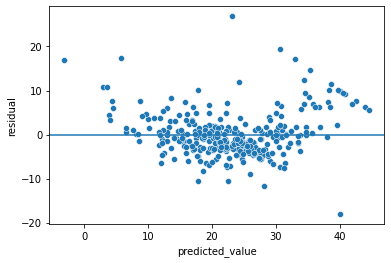

In [23]:
# calculate residuals
residual = y_df_train - y_predict_train

# prepare dataframe
# 1 predictor --> predictor VS residual
df_resid = pd.DataFrame({
    'predicted_value': y_predict_train,
    'residual': residual
})

# residual plot
sns.scatterplot(data=df_resid, x="predicted_value", y="residual")
plt.axhline(0)
plt.show()

Asumsi:
- Linear Relationship = OK (cukup merepresentasikan keseluruhan titik residual)
- Variance Stable = NO (saya pikir variasinya tidak konstan,melebar di kiri dan kanan sementara di tengah terpusat)
- Independent Residual = OK (tidak ada pattern dari residual yang berdekatan)

Regresi dengan regularisasi tidak mengasumsikan asumsi ke 4 yaitu QQ Plot, karena tidak berasumsi residualnya menyebar dengan normal maka QQ plot tidak perlu digambar


#LASSO

In [18]:
from sklearn.linear_model import Lasso

# train the model
X_df_train = feature_df_train.to_numpy()
y_df_train = target_df_train.to_numpy()
y_df_train = y_df_train.reshape(len(y_df_train),)

# define the model
# 4 models with 4 different alphas (lambda)
Lasso_reg_pointzeroone = Lasso(alpha=0.01, random_state=42)
Lasso_reg_pointone = Lasso(alpha=0.1, random_state=42)
Lasso_reg_one = Lasso(alpha=1, random_state=42)
Lasso_reg_ten = Lasso(alpha=10, random_state=42)

# fit the model (training)
Lasso_reg_pointzeroone.fit(X_df_train, y_df_train)
Lasso_reg_pointone.fit(X_df_train, y_df_train)
Lasso_reg_one.fit(X_df_train, y_df_train)
Lasso_reg_ten.fit(X_df_train, y_df_train)

Lasso(alpha=10, random_state=42)

## Find the best model (alpha)
Based on validation set

In [19]:
from sklearn.metrics import mean_squared_error

X_df_validation = feature_df_validation.to_numpy()
y_df_validation = target_df_validation.to_numpy()
y_df_validation = y_df_validation.reshape(len(y_df_validation),)

alphas = [0.01, 0.1, 1., 10]
models = [Lasso_reg_pointzeroone,
          Lasso_reg_pointone,
          Lasso_reg_one,
          Lasso_reg_ten]

for model, alpha in zip(models, alphas):
    y_predict_validation = model.predict(X_df_validation)
    rmse = np.sqrt(mean_squared_error(y_df_validation,y_predict_validation))
    print(f'RMSE of Lasso regression model with alpha = {alpha} is {rmse}')

RMSE of Lasso regression model with alpha = 0.01 is 5.097514590498467
RMSE of Lasso regression model with alpha = 0.1 is 5.08016984806439
RMSE of Lasso regression model with alpha = 1.0 is 4.988309999786157
RMSE of Lasso regression model with alpha = 10 is 5.426622694252769


Lasso with alpha 1 has the smallest RMSE, which means it's the best model.

### Coefficients

In [21]:
Lasso_best = Lasso_reg_one

coef_df = pd.DataFrame({
    'feature':['intercept'] + feature_df_train.columns.tolist(),
    'coefficient':[Lasso_best.intercept_] + list(Lasso_best.coef_)
})

coef_df

,feature,coefficient
0,intercept,22.945673
1,crim,-0.034953
2,zn,0.001941
3,indus,-0.000000
4,chas,0.000000
5,rm,2.572882
6,age,0.041419
7,tax,-0.001003
8,ptratio,-0.757735
9,black,0.011371


kenaikan 1 poin pada rm (Numbers Rooms Average) dengan mengganggap fitur yang lain tetap/tidak ada perubahan akan berasosiasi terhadap kenaikan 2.5 point pada kenaikan *medv (Housing Price)*

#Diagnostic Study


In [24]:
from sklearn.metrics import r2_score

y_predict_train = Lasso_best.predict(X_df_train)

print('R-squared for training data is {}'.format(r2_score(y_df_train, y_predict_train)))

R-squared for training data is 0.6908222586747164


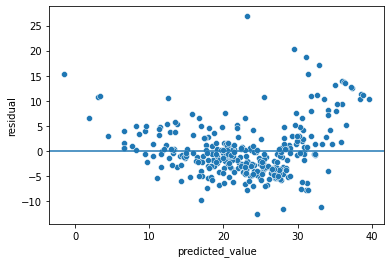

In [25]:
# calculate residuals
residual = y_df_train - y_predict_train

# prepare dataframe
# 1 predictor --> predictor VS residual
df_resid = pd.DataFrame({
    'predicted_value': y_predict_train,
    'residual': residual
})

# residual plot
sns.scatterplot(data=df_resid, x="predicted_value", y="residual")
plt.axhline(0)
plt.show()

Asumsi:
- Linear Relationship = OK (cukup merepresentasikan keseluruhan titik residual)
- Variance Stable = NO (saya pikir variasinya tidak konstan,melebar di kiri dan kanan sementara di tengah terpusat)
- Independent Residual = OK (tidak ada pattern dari residual yang berdekatan)

Regresi dengan regularisasi tidak mengasumsikan asumsi ke 4 yaitu QQ Plot, karena tidak berasumsi residualnya menyebar dengan normal maka QQ plot tidak perlu digambar


## Model Evaluation (RIDGE)

#Training Error

In [26]:
# prepare prediction result on train data
y_predict_train = ridge_best.predict(X_df_train)

In [27]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print('RMSE for training data is {}'.format(np.sqrt(mean_squared_error(y_df_train, y_predict_train))))
print('MAE for training data is {}'.format(mean_absolute_error(y_df_train, y_predict_train)))
print('MAPE for training data is {}'.format(mean_absolute_percentage_error(y_df_train, y_predict_train)))

RMSE for training data is 4.9709140124939095
MAE for training data is 3.5231969534851517
MAPE for training data is 0.1745584290721267


#Testing Error

In [28]:
# prepare prediction result on test data
X_df_test = feature_df_test.to_numpy()
y_predict_test = ridge_best.predict(X_df_test)

# ground truth target
y_df_test = target_df_test.to_numpy()
y_df_test = y_df_test.reshape(len(y_df_test),)

In [29]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print('RMSE for testing data is {}'.format(np.sqrt(mean_squared_error(y_df_test, y_predict_test))))
print('MAE for testing data is {}'.format(mean_absolute_error(y_df_test, y_predict_test)))
print('MAPE for testing data is {}'.format(mean_absolute_percentage_error(y_df_test, y_predict_test)))

RMSE for testing data is 5.446738552406219
MAE for testing data is 3.375222443022143
MAPE for testing data is 0.1820805649593079


## Model Evaluation (LASSO)

#Training Error

In [30]:
# prepare prediction result on train data
y_predict_train = Lasso_best.predict(X_df_train)

In [31]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print('RMSE for training data is {}'.format(np.sqrt(mean_squared_error(y_df_train, y_predict_train))))
print('MAE for training data is {}'.format(mean_absolute_error(y_df_train, y_predict_train)))
print('MAPE for training data is {}'.format(mean_absolute_percentage_error(y_df_train, y_predict_train)))

RMSE for training data is 5.299257784164325
MAE for training data is 3.815568478973893
MAPE for training data is 0.18015928311790003


#Testing Error

In [33]:
# prepare prediction result on test data
X_df_test = feature_df_test.to_numpy()
y_predict_test = Lasso_best.predict(X_df_test)

# ground truth target
y_df_test = target_df_test.to_numpy()
y_df_test = y_df_test.reshape(len(y_df_test),)

In [34]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print('RMSE for testing data is {}'.format(np.sqrt(mean_squared_error(y_df_test, y_predict_test))))
print('MAE for testing data is {}'.format(mean_absolute_error(y_df_test, y_predict_test)))
print('MAPE for testing data is {}'.format(mean_absolute_percentage_error(y_df_test, y_predict_test)))

RMSE for testing data is 5.315646725734099
MAE for testing data is 3.535684907677296
MAPE for testing data is 0.18439385451147544


#CONCLUSION

MODEL RIDGE:
- RMSE pada training dan test data bisa dibilang tidak cukup jauh nilainya, artinya standar deviasi atau residual dari prediksi error sekitar 4.97 untuk Training data dan 5.44 untuk Test data.
- MAE pada Training dan test data juga tidak cukup jauh, artinya rata-rata prediksi pada model menyimpang dari the true value of *medv* sebesar 3.52  untuk training data dan 3.37 untuk test data.
-MAPE 0.174(17.4%) untuk Training data & test data sebesar 0.182 (18.2%),nilai mape sama dengan MAE, hanya saja nilai pada MAPE telah dikonversikan menjadi persen

Nilai MAPE masih dibawah 30% artinya masih acceptable dan bukan ***Underfitting***,sementara Nilai MAPE pada Testing data sebesar 18.2% tidak berbeda signifikan dengan Nilai pada Training data 17.4% artinya bukan juga ***Overfitting*** 

MODEL LASSO:
- RMSE pada training dan test data bisa dibilang tidak cukup jauh nilainya, artinya standar deviasi atau residual dari prediksi error sekitar 5.29 untuk Training data dan 5.31 untuk Test data.
- MAE pada Training dan test data juga tidak cukup jauh, artinya rata-rata prediksi pada model menyimpang dari the true value of *medv* sebesar 3.81 untuk training data dan 3.53 untuk test data.
-MAPE 0.180 (18%) untuk Training data & test data sebesar 0.184 (18.4%),nilai mape sama dengan MAE, hanya saja nilai pada MAPE telah dikonversikan menjadi persen

Nilai MAPE masih dibawah 30% artinya masih acceptable dan bukan ***Underfitting***,sementara Nilai MAPE pada Testing data sebesar 18.4% tidak berbeda signifikan dengan Nilai pada Training data 18% artinya bukan juga ***Overfitting*** 